# Clasificador MNIST 
### Red neuronal profunda

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./BASES/mnist_train.csv', header = None, sep = ',')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
## definir conjuntos de datos en predictores y target
from keras.utils import to_categorical

predictors = df.loc[:, 1:]
target = to_categorical(df.loc[:, 0])

## Partimos conjuntos de train y test
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.01, random_state=42)
print(X_train.shape)
X_train.head()

(59400, 784)


,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
53841,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39810,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
## Escalamiento de los datos
from sklearn.preprocessing import StandardScaler

Sc = StandardScaler().fit(X_train)
X_train = Sc.transform(X_train)
X_test = Sc.transform(X_test)

In [5]:
## Reshape
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop

input_shape = (28, 28, 1)
num_classes = 10

# Construímos modelo secuencial
model = Sequential()

# Definimos arquitectura de las capas
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1,1), activation='relu', input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

## Compilamos el modelo
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


### Aumentamos la cantidad de información

De forma conveniente generamos información artificial, tratando de prevenir con ello problemas por sobreajuste. La idea es alterar los datos de entrenamiento con pequeñas transformaciones para reproducir las variaciones que se presentan cuando alguien escribe un dígito. 

Por ejemplo, los números no están centrados, la escala no es la misma (aveces los mismos números se escriben o mas grandes o mas pequeños), el número tiene una pequeña rotación, etc.

In [7]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


In [8]:
from keras.callbacks import ModelCheckpoint

epochs = 10
batch_size = 20

checkpointer = ModelCheckpoint(filepath='saved_models/CNN_weights_MNIST_3.hdf5', 
                               verbose=1, save_best_only=True)


model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs = epochs, validation_data = (X_test, y_test),
                    verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size, 
                    callbacks=[checkpointer])

Epoch 1/10
 - 2372s - loss: 0.6096 - acc: 0.8355 - val_loss: 0.1535 - val_acc: 0.9767

Epoch 00001: val_loss improved from inf to 0.15355, saving model to saved_models/CNN_weights_MNIST_3.hdf5
Epoch 2/10
 - 2376s - loss: 0.5686 - acc: 0.8963 - val_loss: 0.2597 - val_acc: 0.9367

Epoch 00002: val_loss did not improve from 0.15355
Epoch 3/10
 - 2379s - loss: 1.9828 - acc: 0.8577 - val_loss: 0.4030 - val_acc: 0.9750

Epoch 00003: val_loss did not improve from 0.15355
Epoch 4/10
 - 2378s - loss: 3.1087 - acc: 0.8061 - val_loss: 0.7790 - val_acc: 0.9517

Epoch 00004: val_loss did not improve from 0.15355
Epoch 5/10
 - 2374s - loss: 3.2069 - acc: 0.8003 - val_loss: 0.8059 - val_acc: 0.9500

Epoch 00005: val_loss did not improve from 0.15355
Epoch 6/10
 - 2373s - loss: 3.0567 - acc: 0.8099 - val_loss: 0.8596 - val_acc: 0.9467

Epoch 00006: val_loss did not improve from 0.15355
Epoch 7/10
 - 2371s - loss: 3.2197 - acc: 0.7998 - val_loss: 0.8059 - val_acc: 0.9500

Epoch 00007: val_loss did not 

### Cargamos modelo con mejor validación

In [9]:
model.load_weights('saved_models/CNN_weights_MNIST_3.hdf5')

In [10]:
np.argmax(model.predict(X_test[1].reshape(-1, 28, 28, 1)))
#X_test.shape
#X_test[1].shape

3

In [11]:
predicciones = model.predict(X_test)

pred = pd.Series([np.argmax(x) for x in predicciones], name='Pred')
prob = pd.Series([np.max(x) for x in predicciones], name='Prob')
real = pd.Series([np.argmax(x) for x in y_test], name='real')

resultados = pd.concat([pred, prob, real], axis=1)
resultados.head()

,Pred,Prob,real
0,7,1.000000,7
1,3,1.000000,3
2,8,1.000000,8
3,9,0.999988,9
4,3,1.000000,3


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## Accuracy
test_acc = accuracy_score(resultados.real, resultados.Pred)
print('Test accuracy: {:1.2%}'.format(test_acc))

#print(real.value_counts())
cm = confusion_matrix(pred, real)
cm_nor = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

## Matriz de confusión pro
plt.figure(figsize=(9,9))
sns.heatmap(cm_nor, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Valores actuales', size = 15);
plt.xlabel('Predicciones', size = 15);
all_sample_title = 'Precisión: {:1.2%}'.format(test_acc) 
plt.title(all_sample_title, size = 25);

Test accuracy: 97.67%


### Mas entrenamiento

In [18]:
from keras.callbacks import ModelCheckpoint

batch_size = 20
epochs = 5

checkpointer_2 = ModelCheckpoint(filepath='saved_models/CNN_weights_MNIST_2.hdf5', 
                               verbose=1, save_best_only=True)


model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs = epochs, validation_data = (X_test, y_test),
                    verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size, 
                    callbacks=[checkpointer_2])

Epoch 1/5
 - 805s - loss: 0.0597 - acc: 0.9819 - val_loss: 0.0497 - val_acc: 0.9859

Epoch 00001: val_loss improved from inf to 0.04971, saving model to saved_models/CNN_weights_MNIST_2.hdf5
Epoch 2/5
 - 800s - loss: 0.0535 - acc: 0.9832 - val_loss: 0.0514 - val_acc: 0.9866

Epoch 00002: val_loss did not improve from 0.04971
Epoch 3/5
 - 805s - loss: 0.0538 - acc: 0.9839 - val_loss: 0.0497 - val_acc: 0.9866

Epoch 00003: val_loss improved from 0.04971 to 0.04966, saving model to saved_models/CNN_weights_MNIST_2.hdf5
Epoch 4/5


KeyboardInterrupt: 

## Test conjunto original de test

In [66]:
test = pd.read_csv('./BASES/mnist_test.csv', header = None, sep = ',')

label_test = test.iloc[:, 0]
test = test.iloc[:, 1:]
test.head()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
## Reshape de la base de test
test = Sc.transform(test).reshape(-1, 28, 28, 1)

## Predicciones
pred_test = model.predict(test)

pred = pd.Series([np.argmax(x) for x in pred_test], name='Pred')
prob = pd.Series([np.max(x) for x in pred_test], name='Prob')
real = pd.Series([x for x in label_test], name='real')

res_test = pd.concat([pred, prob, real], axis=1)
res_test.head()

,Pred,Prob,real
0,7,1.000000,7
1,2,1.000000,2
2,1,0.999970,1
3,0,0.997589,0
4,4,0.999996,4


Test accuracy: 98.64%


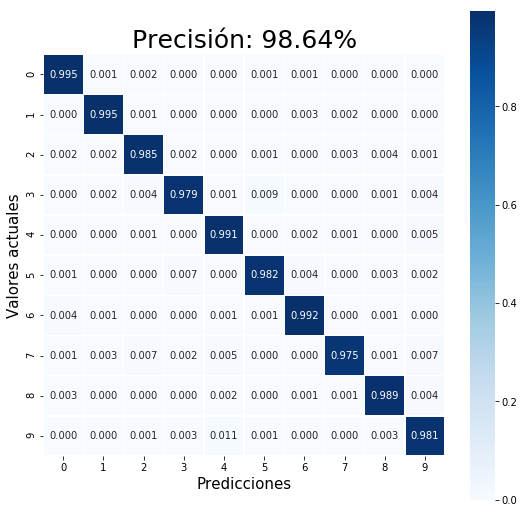

In [68]:
## Accuracy
test_acc = accuracy_score(res_test.real, res_test.Pred)
print('Test accuracy: {:1.2%}'.format(test_acc))

#print(real.value_counts())
cm = confusion_matrix(pred, real)
cm_nor = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

## Matriz de confusión pro
plt.figure(figsize=(9,9))
sns.heatmap(cm_nor, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Valores actuales', size = 15);
plt.xlabel('Predicciones', size = 15);
all_sample_title = 'Precisión: {:1.2%}'.format(test_acc) 
plt.title(all_sample_title, size = 25);